
# Data Quality and Preprocessing Audit

This notebook documents the full cleaning pipeline applied to the telecom training dataset, covering missing value treatment, consistency checks, outlier mitigation, type casting, and feature engineering. Each step is designed to be auditable and reproducible for stakeholders reviewing the project.


## 0. Imports and configuration

In [1]:

import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

NOTEBOOK_CWD = Path(os.getcwd()).resolve()
PROJECT_ROOT = NOTEBOOK_CWD
project_root_candidates = [
    NOTEBOOK_CWD,
    NOTEBOOK_CWD.parent,
    NOTEBOOK_CWD.parent.parent,
    NOTEBOOK_CWD / 'data_science_project',
]
for candidate in project_root_candidates:
    src_dir = (candidate / 'src').resolve()
    if src_dir.exists():
        PROJECT_ROOT = candidate.resolve()
        if str(PROJECT_ROOT) not in sys.path:
            sys.path.append(str(PROJECT_ROOT))
        break

from src.pipelines.preprocessing import (
    load_raw_dataset,
    drop_duplicate_customers,
    impute_missing,
    enforce_consistency,
    cap_outliers,
    cast_dtypes,
    derive_features,
    run_pipeline,
)

pd.set_option('display.max_columns', 50)
sns.set_theme(style='whitegrid', context='talk')
plt.rcParams['figure.figsize'] = (12, 6)
RAW_PATH = PROJECT_ROOT / 'data' / 'raw' / 'training_master_dataset.csv'
PROCESSED_PATH = PROJECT_ROOT / 'data' / 'processed' / 'clean_dataset.csv'


## 1. Load and inspect raw dataset

In [2]:

raw_df = load_raw_dataset(RAW_PATH)
print(f"Raw records: {len(raw_df):,}")
raw_df.head()


Raw records: 20,040


,customer_id,signup_date,last_seen,age,gender,province,lat,lng,plan_type,contract,payment_method,device_type,has_app,has_international_plan,tenure_months,monthly_charges,total_charges,support_tickets_last_6mo,data_usage_gb,calls_per_month,messages_per_month,avg_session_minutes,credit_score,income,late_payments,satisfaction_score,churned,defaulted_loan,next_month_spend,review_text
0,2381,2023-10-04,2025-07-01,37,Male,Matabeleland North,-18.5037,27.6997,Premium,Month-to-Month,NaN,Android,1,0,21,48.99,986.33,3,17.01,59,76,26.40,538.0,4368.38,1,4,0,0,59.47,Support was helpful and response time was decent.
1,8744,2018-05-18,2020-11-22,27,Female,Mashonaland West,-17.1791,30.2245,Prepaid,Month-to-Month,Credit Card,Android,1,0,30,8.88,260.98,0,11.93,39,108,32.68,607.0,13421.71,0,5,0,0,9.73,Love it. Features are exactly what I need.
2,14095,2022-11-11,2023-11-01,28,Male,Midlands,-19.9162,29.9921,Prepaid,One Year,EcoCash,Android,1,0,11,14.10,169.30,0,3.66,41,89,17.35,667.0,NaN,1,5,0,0,24.18,Fantastic experience from start to finish.
3,2860,2019-03-24,2020-05-03,37,Male,Bulawayo,-20.1407,28.6429,Prepaid,Month-to-Month,EcoCash,Android,1,0,13,15.42,186.67,0,8.53,31,92,30.85,486.0,8896.62,2,5,0,1,22.16,Love it. Features are exactly what I need.
4,17946,2020-02-23,2020-10-12,18,Female,Matabeleland South,-20.7940,29.4687,Postpaid,Two Year,Debit Card,iOS,1,1,7,34.55,244.79,2,8.83,44,64,24.68,670.0,6673.12,0,5,0,0,44.83,Love it. Features are exactly what I need.


In [3]:

raw_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20040 entries, 0 to 20039
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_id               20040 non-null  int64         
 1   signup_date               20040 non-null  datetime64[ns]
 2   last_seen                 20040 non-null  datetime64[ns]
 3   age                       20040 non-null  int64         
 4   gender                    20040 non-null  object        
 5   province                  20040 non-null  object        
 6   lat                       20040 non-null  float64       
 7   lng                       20040 non-null  float64       
 8   plan_type                 20040 non-null  object        
 9   contract                  20040 non-null  object        
 10  payment_method            19641 non-null  object        
 11  device_type               20040 non-null  object        
 12  has_app           

### 1.1 Missingness overview

In [4]:

missing_pct = (raw_df.isna().mean() * 100).sort_values(ascending=False)
missing_pct.to_frame('missing_pct').head(10)


,missing_pct
income,7.864271
credit_score,4.835329
data_usage_gb,3.882236
avg_session_minutes,3.283433
payment_method,1.991018
review_text,1.017964
province,0.000000
lat,0.000000
plan_type,0.000000
customer_id,0.000000


C:\Users\kkadema.SIRDC\AppData\Local\Temp\ipykernel_14816\3952462265.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_pct.index, y=missing_pct.values, ax=ax, palette='viridis')


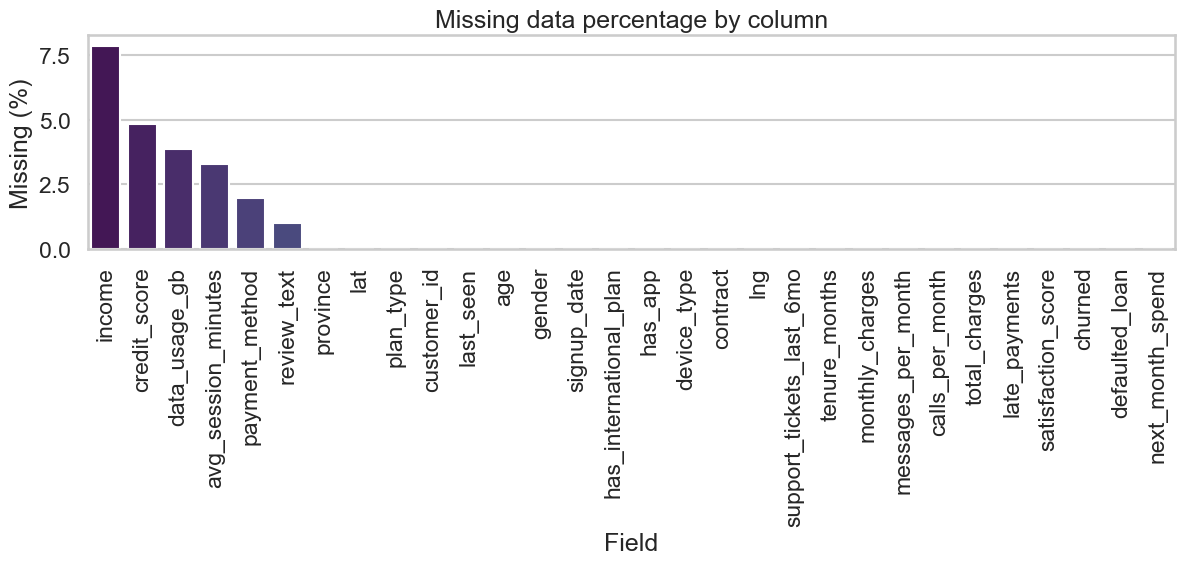

In [5]:

fig, ax = plt.subplots()
sns.barplot(x=missing_pct.index, y=missing_pct.values, ax=ax, palette='viridis')
ax.set_ylabel('Missing (%)')
ax.set_xlabel('Field')
ax.set_title('Missing data percentage by column')
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()


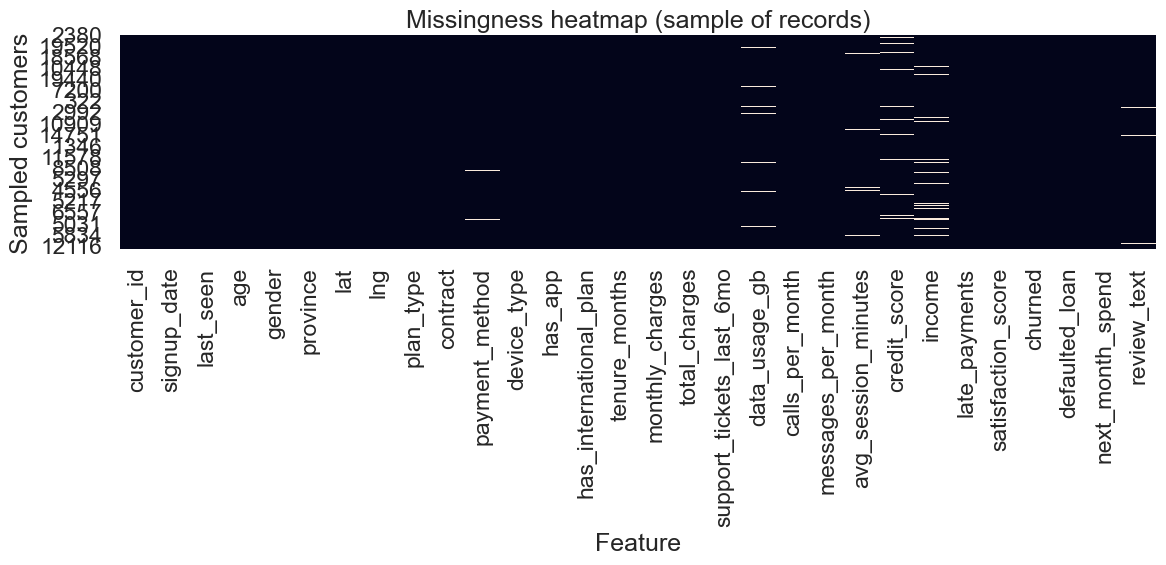

In [6]:

sample_for_heatmap = raw_df.sample(n=min(500, len(raw_df)), random_state=42)
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(sample_for_heatmap.isna(), cbar=False, ax=ax)
ax.set_title('Missingness heatmap (sample of records)')
ax.set_xlabel('Feature')
ax.set_ylabel('Sampled customers')
plt.tight_layout()


### 1.2 Duplicate assessment

In [7]:

duplicate_count = raw_df.duplicated(subset=['customer_id']).sum()
full_duplicate_count = raw_df.duplicated().sum()
print(f"Duplicate customer_id entries: {duplicate_count}")
print(f"Fully duplicated rows: {full_duplicate_count}")


Duplicate customer_id entries: 40
Fully duplicated rows: 40


## 2. Cleaning workflow

### 2.1 Deduplicate and impute missing values

In [8]:

dedup_df = drop_duplicate_customers(raw_df)
print(f"Records after deduplication: {len(dedup_df):,}")
missing_before = (dedup_df.isna().mean() * 100).sort_values(ascending=False)
missing_before.head()


Records after deduplication: 20,000


income                 7.860
credit_score           4.840
data_usage_gb          3.880
avg_session_minutes    3.275
payment_method         1.990
dtype: float64

In [9]:

imputed_df = impute_missing(dedup_df)
missing_after = (imputed_df.isna().mean() * 100).sort_values(ascending=False)
missing_after.head()


customer_id    0.0
signup_date    0.0
last_seen      0.0
age            0.0
gender         0.0
dtype: float64

In [10]:

missing_summary = pd.DataFrame({'before_imputation': missing_before, 'after_imputation': missing_after}).head(10)
missing_summary


,before_imputation,after_imputation
age,0.000,0.0
avg_session_minutes,3.275,0.0
calls_per_month,0.000,0.0
churned,0.000,0.0
contract,0.000,0.0
credit_score,4.840,0.0
customer_id,0.000,0.0
data_usage_gb,3.880,0.0
defaulted_loan,0.000,0.0
device_type,0.000,0.0


### 2.2 Consistency checks (dates and tenure)

In [11]:

inconsistent_dates = (imputed_df['last_seen'] < imputed_df['signup_date']).sum()
print(f"Rows where last_seen < signup_date: {inconsistent_dates}")

tenure_computed = ((imputed_df['last_seen'] - imputed_df['signup_date']).dt.days / 30.4375)
tenure_gap = (imputed_df['tenure_months'] - tenure_computed).abs()
print(f"Rows with tenure difference > 3 months: {(tenure_gap > 3).sum()}")


Rows where last_seen < signup_date: 0
Rows with tenure difference > 3 months: 0


In [12]:

consistent_df = enforce_consistency(imputed_df)
inconsistent_dates_after = (consistent_df['last_seen'] < consistent_df['signup_date']).sum()

adjusted_tenure_gap = (
    consistent_df['tenure_months']
    - ((consistent_df['last_seen'] - consistent_df['signup_date']).dt.days / 30.4375)
).abs()

print(f"Remaining rows with inconsistent dates: {inconsistent_dates_after}")
print(f"Rows with tenure difference > 3 months after correction: {(adjusted_tenure_gap > 3).sum()}")


Remaining rows with inconsistent dates: 0
Rows with tenure difference > 3 months after correction: 0


### 2.3 Outlier detection and mitigation

In [13]:

numeric_cols = [
    'monthly_charges',
    'total_charges',
    'data_usage_gb',
    'calls_per_month',
    'messages_per_month',
    'avg_session_minutes',
    'credit_score',
    'income',
    'late_payments',
    'next_month_spend'
]

outlier_counts = {}
for col in numeric_cols:
    series = consistent_df[col].dropna()
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    outlier_counts[col] = ((series < lower) | (series > upper)).sum()

pd.Series(outlier_counts).to_frame('iqr_outliers').sort_values('iqr_outliers', ascending=False)


,iqr_outliers
total_charges,1167
next_month_spend,1155
monthly_charges,995
income,833
late_payments,821
data_usage_gb,481
calls_per_month,358
credit_score,220
avg_session_minutes,193
messages_per_month,101


In [14]:

capped_df = cap_outliers(consistent_df)
comparison = pd.DataFrame({
    'original': consistent_df['income'],
    'capped': capped_df['income']
})
comparison.describe()


,original,capped
count,20000.000000,20000.000000
mean,7465.564351,7185.738982
std,6141.142976,2944.598628
min,952.570000,952.570000
25%,5030.857500,5030.857500
50%,6674.405000,6674.405000
75%,8764.115000,8764.115000
max,170382.450000,14364.001250


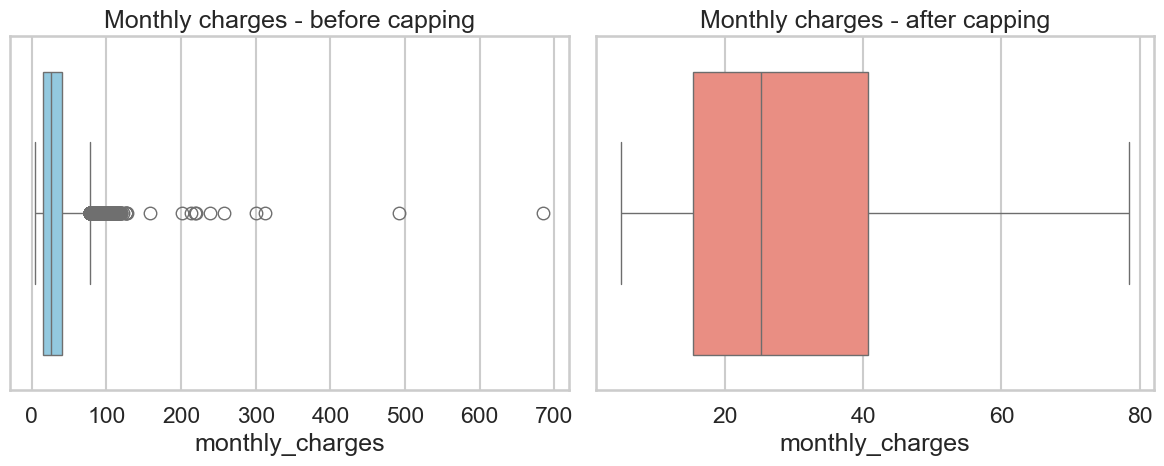

In [15]:

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x=consistent_df['monthly_charges'], ax=axes[0], color='skyblue')
axes[0].set_title('Monthly charges - before capping')
sns.boxplot(x=capped_df['monthly_charges'], ax=axes[1], color='salmon')
axes[1].set_title('Monthly charges - after capping')
plt.tight_layout()


### 2.4 Type casting

In [16]:

typed_df = cast_dtypes(capped_df)
typed_df.dtypes.head(15)


customer_id                        int64
signup_date               datetime64[ns]
last_seen                 datetime64[ns]
age                                int64
gender                          category
province                        category
lat                              float64
lng                              float64
plan_type                       category
contract                        category
payment_method                  category
device_type                     category
has_app                             bool
has_international_plan              bool
tenure_months                      int64
dtype: object

### 2.5 Feature engineering

In [17]:

enriched_df = derive_features(typed_df)
feature_preview = enriched_df[[
    'tenure_years',
    'support_tickets_per_month',
    'avg_monthly_revenue',
    'spend_to_income_ratio',
    'charges_per_gb',
    'engagement_intensity',
    'lifetime_value_projection'
]].head()
feature_preview


,tenure_years,support_tickets_per_month,avg_monthly_revenue,spend_to_income_ratio,charges_per_gb,engagement_intensity,lifetime_value_projection
0,2.33,0.000,19.890000,0.027611,4.845266,42.33,941.28
1,0.67,0.167,42.280000,0.088129,4.814234,16.74,855.32
2,0.08,0.167,33.140000,0.028691,2.143939,29.46,33.14
3,0.67,0.167,19.198750,0.039658,1.307536,38.40,153.59
4,1.83,0.000,14.855455,0.029844,3.683951,25.90,476.22


### 2.6 Final pipeline execution and export

In [18]:

clean_df = run_pipeline(RAW_PATH, PROCESSED_PATH)
print(f"Cleaned dataset rows: {len(clean_df):,}")
print(f"Nulls remaining: {int(clean_df.isna().sum().sum())}")
clean_df.head()


Cleaned dataset rows: 20,000
Nulls remaining: 0


,customer_id,signup_date,last_seen,age,gender,province,lat,lng,plan_type,contract,payment_method,device_type,has_app,has_international_plan,tenure_months,monthly_charges,total_charges,support_tickets_last_6mo,data_usage_gb,calls_per_month,messages_per_month,avg_session_minutes,credit_score,income,late_payments,satisfaction_score,churned,defaulted_loan,next_month_spend,review_text,tenure_years,support_tickets_per_month,avg_monthly_revenue,spend_to_income_ratio,charges_per_gb,engagement_intensity,lifetime_value_projection
0,1,2020-08-15,2022-12-16,30,Male,Matabeleland North,-18.6203,27.6337,Prepaid,Month-to-Month,EcoCash,Android,True,True,28,20.98,556.92,0,4.33,67,95,30.88,718.0,9118.00,0,5,False,False,32.03,Fantastic experience from start to finish.,2.33,0.000,19.890000,0.027611,4.845266,42.33,941.28
1,2,2024-08-27,2025-05-11,31,Male,Mashonaland West,-17.2211,30.1817,Postpaid,One Year,Debit Card,iOS,False,False,8,39.91,338.24,1,8.29,33,82,9.34,711.0,5434.28,0,5,False,False,43.09,"Excellent! Fast, reliable, and great support.",0.67,0.167,42.280000,0.088129,4.814234,16.74,855.32
2,3,2023-02-14,2023-03-30,38,Male,Manicaland,-19.0543,32.5927,Postpaid,Month-to-Month,Credit Card,iOS,True,False,1,33.96,33.14,1,15.84,41,77,21.51,626.0,14203.52,0,5,True,False,26.88,"Excellent! Fast, reliable, and great support.",0.08,0.167,33.140000,0.028691,2.143939,29.46,33.14
3,4,2022-03-11,2022-12-04,57,Female,Masvingo,-20.5122,30.8098,Prepaid,One Year,EcoCash,Android,True,False,8,19.26,153.59,1,14.73,47,79,29.75,690.0,5827.76,0,5,True,False,20.44,Fantastic experience from start to finish.,0.67,0.167,19.198750,0.039658,1.307536,38.40,153.59
4,5,2019-02-03,2020-12-05,18,Male,Bulawayo,-20.4335,28.6515,Prepaid,Month-to-Month,EcoCash,Android,True,False,22,14.92,326.82,0,4.05,38,92,17.50,573.0,5999.19,0,4,False,True,12.45,Pretty satisfied with the features for the price.,1.83,0.000,14.855455,0.029844,3.683951,25.90,476.22


In [19]:

processed_path = PROCESSED_PATH
processed_path, (PROCESSED_PATH.exists())


(WindowsPath('C:/Users/kkadema.SIRDC/Desktop/data analysis/data_science_project/data/processed/clean_dataset.csv'),
 True)

## 3. Quality checks on the processed dataset

In [20]:

summary = clean_df.describe(include='all').T
summary[['count', 'mean', 'std', 'min', 'max']].head(10)


,count,mean,std,min,max
customer_id,20000.0,10000.5,5773.647028,1.0,20000.0
signup_date,20000,2021-06-29 19:46:16.320000,NaN,2018-01-01 00:00:00,2024-12-30 00:00:00
last_seen,20000,2022-11-25 13:46:07.679999744,NaN,2018-01-09 00:00:00,2025-09-30 00:00:00
age,20000.0,34.693,9.568366,18.0,77.0
gender,20000,NaN,NaN,NaN,NaN
province,20000,NaN,NaN,NaN,NaN
lat,20000.0,-18.879943,1.286645,-21.6306,-16.1507
lng,20000.0,30.31407,1.516392,26.7921,33.3467
plan_type,20000,NaN,NaN,NaN,NaN
contract,20000,NaN,NaN,NaN,NaN


In [21]:

clean_df.select_dtypes(include='category').nunique()


gender                 3
province              10
plan_type              3
contract               3
payment_method         5
device_type            3
satisfaction_score     4
dtype: int64


The cleaned dataset is now persisted to data/processed/clean_dataset.csv and ready for analytical modeling and reporting workflows.
